<a href="https://colab.research.google.com/github/skhosanam/ml-dl-classification/blob/main/Deep_learning_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow
!pip install transformers

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D, Concatenate
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fakeNews.csv to fakeNews.csv
Saving trueNews.csv to trueNews.csv


In [ ]:
# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)


In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_texts(texts, max_len=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.concatenate(input_ids, axis=0), np.concatenate(attention_masks, axis=0)

X_train_ids, X_train_attention = encode_texts(X_train)
X_test_ids, X_test_attention = encode_texts(X_test)


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In t

In [ ]:
import tensorflow as tf
from transformers import TFDistilBertModel, DistilBertTokenizer
from tensorflow.keras.layers import Input, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.models import Model

# Load smaller pre-trained model (DistilBERT)
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Reduce sequence length
max_length = 128  # Experiment with this value

# Build model
input_ids = Input(shape=(max_length,), dtype=tf.int32)
attention_mask = Input(shape=(max_length,), dtype=tf.int32)
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
conv_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(bert_output)
max_pool = GlobalMaxPooling1D()(conv_layer)
output = Dense(1, activation='sigmoid')(max_pool)
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Prepare data (tokenization and padding) for X_train_ids and X_train_attention
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Assume X_train is training data and y_train are the labels
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_train_ids = X_train_encodings['input_ids']
X_train_attention = X_train_encodings['attention_mask']

# Increase batch size if possible
batch_size = 16  # Experiment with this value

# Train model
model.fit([X_train_ids, X_train_attention], y_train, epochs=2, batch_size=batch_size)


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/2
380/380 [==============================] - 429s 1s/step - loss: 0.7123 - accuracy: 0.5148
Epoch 2/2
380/380 [==============================] - 410s 1s/step - loss: 0.6932 - accuracy: 0.5016


In [ ]:
# Tokenize and pad the test data
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_test_ids = X_test_encodings['input_ids']
X_test_attention = X_test_encodings['attention_mask']

# Make predictions
predictions = model.predict([X_test_ids, X_test_attention])
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy and F1 score
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f"Accuracy: {acc}, F1 Score: {f1}")


48/48 [==============================] - 32s 640ms/step
Accuracy: 0.48221343873517786, F1 Score: 0.6506666666666667


In [ ]:
##

In [ ]:
import pandas as pd
import tensorflow as tf
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv1D, GlobalMaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)

# Initialize DistilBERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Define function to encode texts
def encode_texts(texts, max_len=128):  # Adjusted max_len for DistilBERT
    return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=max_len, return_tensors='tf')

# Encode training and testing data
X_train_encodings = encode_texts(X_train)
X_test_encodings = encode_texts(X_test)

# Load pre-trained DistilBERT model
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Build model
input_ids = Input(shape=(128,), dtype=tf.int32)  # Adjusted shape for DistilBERT
attention_mask = Input(shape=(128,), dtype=tf.int32)
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
conv_layer = Conv1D(filters=128, kernel_size=3, activation='relu')(bert_output)
max_pool = GlobalMaxPooling1D()(conv_layer)
output = Dense(1, activation='sigmoid')(max_pool)
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
batch_size = 16  # Experiment with this value
model.fit([X_train_encodings['input_ids'], X_train_encodings['attention_mask']], y_train, epochs=2, batch_size=batch_size)

# Make predictions on the test set
predictions = model.predict([X_test_encodings['input_ids'], X_test_encodings['attention_mask']])
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy and F1 score
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f"Accuracy: {acc}, F1 Score: {f1}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/2
380/380 [==============================] - 450s 1s/step - loss: 0.7249 - accuracy: 0.4868
Epoch 2/2
48/48 [==============================] - 34s 661ms/step
Accuracy: 0.48221343873517786, F1 Score: 0.6506666666666667


In [ ]:
##

In [ ]:
import pandas as pd
import numpy as np
import gensim
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)


In [ ]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return text

sentences = [preprocess_text(text) for text in X_train]


In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


In [ ]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_seq_length = 500  # Adjust based on dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Create an embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Should match the Word2Vec vector size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [ ]:
# Build CNN model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
171/171 [==============================] - 4s 19ms/step - loss: 0.0933 - accuracy: 0.9630 - val_loss: 0.0448 - val_accuracy: 0.9835
Epoch 2/5
171/171 [==============================] - 3s 16ms/step - loss: 0.0423 - accuracy: 0.9868 - val_loss: 0.0288 - val_accuracy: 0.9901
Epoch 3/5
171/171 [==============================] - 3s 15ms/step - loss: 0.0331 - accuracy: 0.9901 - val_loss: 0.0220 - val_accuracy: 0.9934
Epoch 4/5
171/171 [==============================] - 3s 15ms/step - loss: 0.0264 - accuracy: 0.9918 - val_loss: 0.0175 - val_accuracy: 0.9951
Epoch 5/5
171/171 [==============================] - 3s 15ms/step - loss: 0.0208 - accuracy: 0.9934 - val_loss: 0.0158 - val_accuracy: 0.9967


In [ ]:
# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy and F1 score
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f"Accuracy: {acc}, F1 Score: {f1}")


48/48 [==============================] - 0s 4ms/step
Accuracy: 0.9828722002635046, F1 Score: 0.9819444444444445


In [ ]:
!pip install tensorflow
!pip install transformers
!pip install gensim

In [ ]:
import pandas as pd
import numpy as np
import gensim
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)


In [ ]:
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return text

sentences = [preprocess_text(text) for text in X_train]


In [ ]:
from gensim.models import Word2Vec

# Train Word2Vec model
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)


In [ ]:
# Initialize and fit the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences
max_seq_length = 500  # Adjust based on dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_seq_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_seq_length)

# Create an embedding matrix
vocab_size = len(tokenizer.word_index) + 1
embedding_dim = 100  # Should match the Word2Vec vector size
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]


In [ ]:
# Build LSTM model
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_seq_length, trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_pad, y_train, epochs=5, batch_size=32, validation_split=0.1)


Epoch 1/5
171/171 [==============================] - 68s 383ms/step - loss: 0.0885 - accuracy: 0.9779 - val_loss: 0.0416 - val_accuracy: 0.9852
Epoch 2/5
171/171 [==============================] - 64s 372ms/step - loss: 0.0395 - accuracy: 0.9887 - val_loss: 0.0161 - val_accuracy: 0.9967
Epoch 3/5
171/171 [==============================] - 63s 370ms/step - loss: 0.0345 - accuracy: 0.9907 - val_loss: 0.0240 - val_accuracy: 0.9967
Epoch 4/5
171/171 [==============================] - 64s 376ms/step - loss: 0.0283 - accuracy: 0.9925 - val_loss: 0.0109 - val_accuracy: 0.9967
Epoch 5/5
171/171 [==============================] - 64s 374ms/step - loss: 0.0233 - accuracy: 0.9932 - val_loss: 0.0105 - val_accuracy: 0.9967


In [ ]:
# Make predictions
predictions = model.predict(X_test_pad)
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy and F1 score
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f"Accuracy: {acc}, F1 Score: {f1}")


48/48 [==============================] - 8s 149ms/step
Accuracy: 0.994729907773386, F1 Score: 0.9945054945054945


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score


In [ ]:
# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine datasets
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Text'], combined_df['label'], test_size=0.2, random_state=42)


In [ ]:
# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('distilbert-base-uncased')

def encode_texts(texts, max_len=512):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='tf',
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.concatenate(input_ids, axis=0), np.concatenate(attention_masks, axis=0)

X_train_ids, X_train_attention = encode_texts(X_train)
X_test_ids, X_test_attention = encode_texts(X_test)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'DistilBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In t

In [ ]:
# Load BERT model
bert_model = TFBertModel.from_pretrained('distilbert-base-uncased')

# Build model
input_ids = Input(shape=(512,), dtype=tf.int32)
attention_mask = Input(shape=(512,), dtype=tf.int32)
bert_output = bert_model(input_ids, attention_mask=attention_mask)[0]
lstm_layer = LSTM(units=64, return_sequences=False)(bert_output)
output = Dense(1, activation='sigmoid')(lstm_layer)
model = Model(inputs=[input_ids, attention_mask], outputs=output)

# Compile model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit([X_train_ids, X_train_attention], y_train, epochs=2, batch_size=8)


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['distilbert.transformer.layer.1.attention.q_lin.weight', 'vocab_layer_norm.bias', 'distilbert.transformer.layer.4.ffn.lin2.weight', 'distilbert.transformer.layer.2.ffn.lin2.bias', 'distilbert.transformer.layer.1.output_layer_norm.weight', 'distilbert.transformer.layer.2.attention.out_lin.bias', 'distilbert.transformer.layer.2.ffn.lin2.weight', 'distilbert.transformer.layer.2.attention.q_lin.bias', 'distilbert.transformer.layer.3.attention.v_lin.bias', 'distilbert.transformer.layer.3.sa_layer_norm.bias', 'distilbert.transformer.layer.1.ffn.lin1.bias', 'distilbert.transformer.layer.1.ffn.lin1.weight', 'distilbert.transformer.layer.0.attention.v_lin.bias', 'distilbert.transformer.layer.5.attention.v_lin.weight', 'distilbert.transformer.layer

Epoch 1/2


759/759 [==============================] - 829s 1s/step - loss: 0.6966 - accuracy: 0.5049
Epoch 2/2
759/759 [==============================] - 782s 1s/step - loss: 0.6940 - accuracy: 0.4954


In [ ]:
# Make predictions
predictions = model.predict([X_test_ids, X_test_attention])
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy and F1 score
acc = accuracy_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

print(f"Accuracy: {acc}, F1 Score: {f1}")


48/48 [==============================] - 66s 1s/step
Accuracy: 0.48221343873517786, F1 Score: 0.6506666666666667


In [ ]:
#Hybrid models

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from gensim.models import Word2Vec
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Conv1D, MaxPooling1D, Flatten, Concatenate
from transformers import DistilBertTokenizer, TFDistilBertModel

# Load the attached datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Preprocess data
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return ' '.join(text)

combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Train Word2Vec model
sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, sg=0)

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
vocab_size = len(tokenizer.word_index) + 1
max_seq_length = max([len(text.split()) for text in X_train])

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(X_train_seq, maxlen=max_seq_length, padding='post')

# Create embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

# Model architecture with Word2Vec embeddings
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=max_seq_length, trainable=False)(input_layer)

conv_layer = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding_layer)
max_pool = MaxPooling1D(pool_size=2)(conv_layer)
lstm_layer = LSTM(32)(max_pool)
output_layer = Dense(1, activation='sigmoid')(lstm_layer)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=3, batch_size=32)

# Tokenization and padding for test data
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_seq_length, padding='post')

# Evaluate the model
y_pred = model.predict(X_test_padded)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


Epoch 1/3
190/190 [==============================] - 5s 8ms/step - loss: 0.2236 - accuracy: 0.9277
Epoch 2/3
190/190 [==============================] - 1s 7ms/step - loss: 0.0587 - accuracy: 0.9845
Epoch 3/3
48/48 [==============================] - 1s 5ms/step
Accuracy: 0.9927536231884058
F1 Score: 0.9924294562973159


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

# Load the attached datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])

# Preprocess data
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]  # Remove all numbers and punctuation
    return ' '.join(text)

combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Load DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Tokenization and padding
max_length = 256
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Extract embeddings from DistilBERT
X_train_embeddings = bert_model(X_train_encodings)[0].numpy()  # Convert tensor to numpy array
X_test_embeddings = bert_model(X_test_encodings)[0].numpy()    # Convert tensor to numpy array

# Function to pad the sequences
def pad_embeddings(embeddings, max_length):
    padded_embeddings = np.zeros((len(embeddings), max_length, embeddings.shape[2]))
    for i, embedding in enumerate(embeddings):
        length = min(max_length, embedding.shape[0])
        padded_embeddings[i, :length] = embedding[:length]
    return padded_embeddings

# Pad the embeddings
X_train_padded = pad_embeddings(X_train_embeddings, max_length)
X_test_padded = pad_embeddings(X_test_embeddings, max_length)

# Create a sequential model for CNN+LSTM
model = Sequential()

# CNN layer
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(max_length, 768)))
model.add(MaxPooling1D(pool_size=4))

# LSTM layer
model.add(LSTM(50))

# Output layer
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=3, batch_size=8)

# Evaluate the model
y_pred = model.predict(X_test_padded)
y_pred_binary = [1 if pred >= 0.5 else 0 for pred in y_pred]

accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)

print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected i

Epoch 1/3
759/759 [==============================] - 22s 25ms/step - loss: 0.5742 - accuracy: 0.6667
Epoch 2/3
759/759 [==============================] - 19s 25ms/step - loss: 0.0722 - accuracy: 0.9811
Epoch 3/3
48/48 [==============================] - 1s 12ms/step
Accuracy: 0.9940711462450593
F1 Score: 0.9938566552901024


In [ ]:
#Pre-trained language models

In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from transformers import DistilBertTokenizer, TFDistilBertModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]
    return ' '.join(text)

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])
combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Tokenization for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
max_length = 128
X_train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')
X_test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True, max_length=max_length, return_tensors='tf')

# Load DistilBERT model
distilbert_model = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

# Extract embeddings
def get_embeddings(model, tokenized_data):
    return model(tokenized_data)[0][:,0,:].numpy()

X_train_embeddings = get_embeddings(distilbert_model, X_train_encodings)
X_test_embeddings = get_embeddings(distilbert_model, X_test_encodings)

# Build classification model
input_layer = Input(shape=(X_train_embeddings.shape[1],))
dense_layer = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Custom Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=0.898, epsilon=1e-7)

# Compile model
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train model
model.fit(X_train_embeddings, y_train, epochs=3, batch_size=8)

# Evaluate model
y_pred = model.predict(X_test_embeddings)
y_pred_binary = (y_pred > 0.5).astype(int)
accuracy = accuracy_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
conf_matrix = confusion_matrix(y_test, y_pred_binary)

print(f"DistilBERT Classifier - Accuracy: {accuracy}, F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected i

Epoch 1/3
759/759 [==============================] - 2s 1ms/step - loss: 0.2287 - accuracy: 0.9353
Epoch 2/3
759/759 [==============================] - 1s 1ms/step - loss: 0.0907 - accuracy: 0.9725
Epoch 3/3
48/48 [==============================] - 0s 1ms/step
DistilBERT Classifier - Accuracy: 0.9802371541501976, F1 Score: 0.9795918367346939
Confusion Matrix:
[[768  18]
 [ 12 720]]


In [ ]:
import pandas as pd
import numpy as np
import re
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from transformers import RobertaTokenizer, TFRobertaModel
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Preprocess text function
def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = text.lower().split()
    text = [word for word in text if word.isalpha()]
    return ' '.join(text)

# Load datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')

# Combine data and create labels
fake_news_df['label'] = 0
true_news_df['label'] = 1
combined_df = pd.concat([fake_news_df, true_news_df])
combined_df['Processed_Content'] = combined_df['Text'].apply(preprocess_text)

# Split data
X_train, X_test, y_train, y_test = train_test_split(combined_df['Processed_Content'], combined_df['label'], test_size=0.2, random_state=42)

# Tokenization settings
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_length = 128

# Load RoBERTa model
roberta_model = TFRobertaModel.from_pretrained('roberta-base')

# Generator to yield batches of data
def batch_encode(tokenizer, texts, batch_size=32):
    for i in range(0, len(texts), batch_size):
        texts_batch = texts[i:i+batch_size].tolist()
        encodings = tokenizer(texts_batch, padding=True, truncation=True, max_length=max_length, return_tensors='tf')
        yield encodings

# Build classification model
input_layer = Input(shape=(768,))
dense_layer = Dense(64, activation='relu')(input_layer)
output_layer = Dense(1, activation='sigmoid')(dense_layer)
model = Model(inputs=input_layer, outputs=output_layer)

# Custom Adam optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.8, beta_2=0.898, epsilon=1e-7)

# Compile model
model.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Training and evaluation loop
batch_size = 8
for epoch in range(3):
    print(f"Epoch {epoch+1}/3")
    # Training
    for batch_idx, batch in enumerate(batch_encode(tokenizer, X_train, batch_size=batch_size)):
        embeddings = roberta_model(batch)[0][:,0,:]  # Get the embeddings of the first token ([CLS])
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch['input_ids'].shape[0]
        model.train_on_batch(embeddings, y_train[start_idx:end_idx])

# Evaluation
y_pred = []
for batch in batch_encode(tokenizer, X_test, batch_size=batch_size):
    embeddings = roberta_model(batch)[0][:,0,:]  # Get the embeddings of the first token ([CLS])
    y_pred.extend(model.predict_on_batch(embeddings))

y_pred_binary = np.array(y_pred).flatten() > 0.5
accuracy = accuracy_score(y_test[:len(y_pred_binary)], y_pred_binary)
f1 = f1_score(y_test[:len(y_pred_binary)], y_pred_binary)
conf_matrix = confusion_matrix(y_test[:len(y_pred_binary)], y_pred_binary)

print(f"RoBERTa Classifier - Accuracy: {accuracy}, F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'roberta.embeddings.position_ids', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

Epoch 1/3
Epoch 2/3
Epoch 3/3
RoBERTa Classifier - Accuracy: 0.9769433465085638, F1 Score: 0.9759780370624571
Confusion Matrix:
[[772  14]
 [ 21 711]]


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving classifier_performance_MK.csv to classifier_performance_MK (2).csv


<Figure size 1200x600 with 0 Axes>

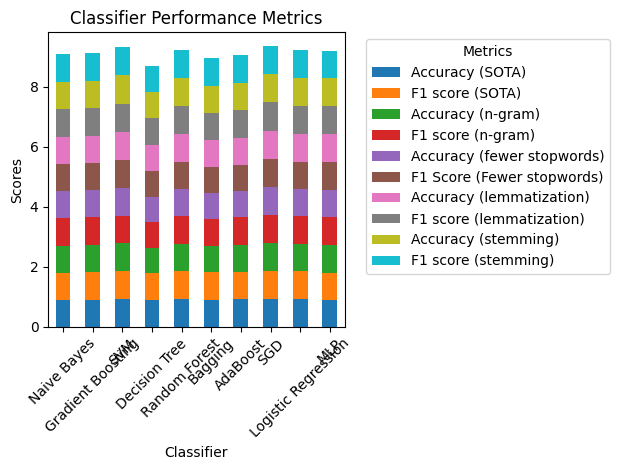

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the data
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'Accuracy (SOTA)': [0.8945, 0.9064, 0.9308, 0.891, 0.9238, 0.9043, 0.9133, 0.928, 0.9224, 0.9015],
    'F1 score (SOTA)': [0.8995, 0.9158, 0.9358, 0.8942, 0.9278, 0.9085, 0.9192, 0.9323, 0.928, 0.9031],
    'Accuracy (n-gram)': [0.9085, 0.914, 0.9182, 0.847, 0.9175, 0.8833, 0.9099, 0.9315, 0.9105, 0.9196],
    'F1 score (n-gram)': [0.9147, 0.9213, 0.9255, 0.8461, 0.9192, 0.8838, 0.9146, 0.9368, 0.9185, 0.9226],
    'Accuracy (fewer stopwords)': [0.9107, 0.9002, 0.9218, 0.8583, 0.9009, 0.873, 0.8667, 0.9386, 0.9121, 0.9316],
    'F1 Score (Fewer stopwords)': [0.9139, 0.9047, 0.9255, 0.8519, 0.8957, 0.8668, 0.8617, 0.9408, 0.916, 0.9317],
    'Accuracy (lemmatization)': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'F1 score (lemmatization)': [0.906, 0.9203, 0.9441, 0.8798, 0.935, 0.9062, 0.9212, 0.9401, 0.9341, 0.9305],
    'Accuracy (stemming)': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
    'F1 score (stemming)': [0.9194, 0.9187, 0.941, 0.8808, 0.9362, 0.9132, 0.9169, 0.935, 0.9297, 0.9129]
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Classifier column as the index (optional)
df.set_index('Classifier', inplace=True)

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
df.plot(kind='bar', stacked=True, rot=45)
plt.title('Classifier Performance Metrics')
plt.xlabel('Classifier')
plt.ylabel('Scores')
plt.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



<Figure size 1200x600 with 0 Axes>

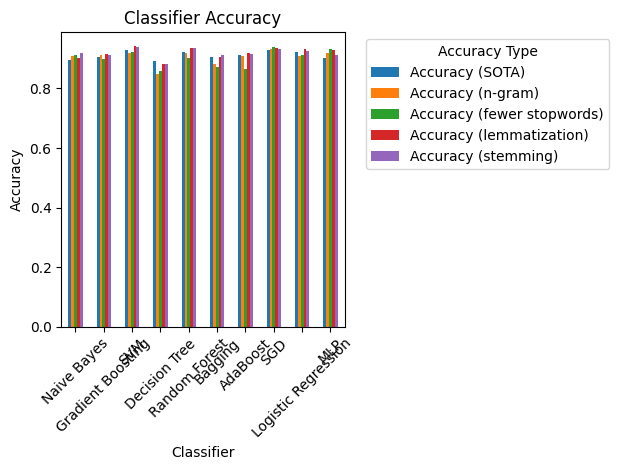

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the data for accuracy only
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'Accuracy (SOTA)': [0.8945, 0.9064, 0.9308, 0.891, 0.9238, 0.9043, 0.9133, 0.928, 0.9224, 0.9015],
    'Accuracy (n-gram)': [0.9085, 0.914, 0.9182, 0.847, 0.9175, 0.8833, 0.9099, 0.9315, 0.9105, 0.9196],
    'Accuracy (fewer stopwords)': [0.9107, 0.9002, 0.9218, 0.8583, 0.9009, 0.873, 0.8667, 0.9386, 0.9121, 0.9316],
    'Accuracy (lemmatization)': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Accuracy (stemming)': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Classifier column as the index (optional)
df.set_index('Classifier', inplace=True)

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
df.plot(kind='bar', rot=45)
plt.title('Classifier Accuracy')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.legend(title='Accuracy Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


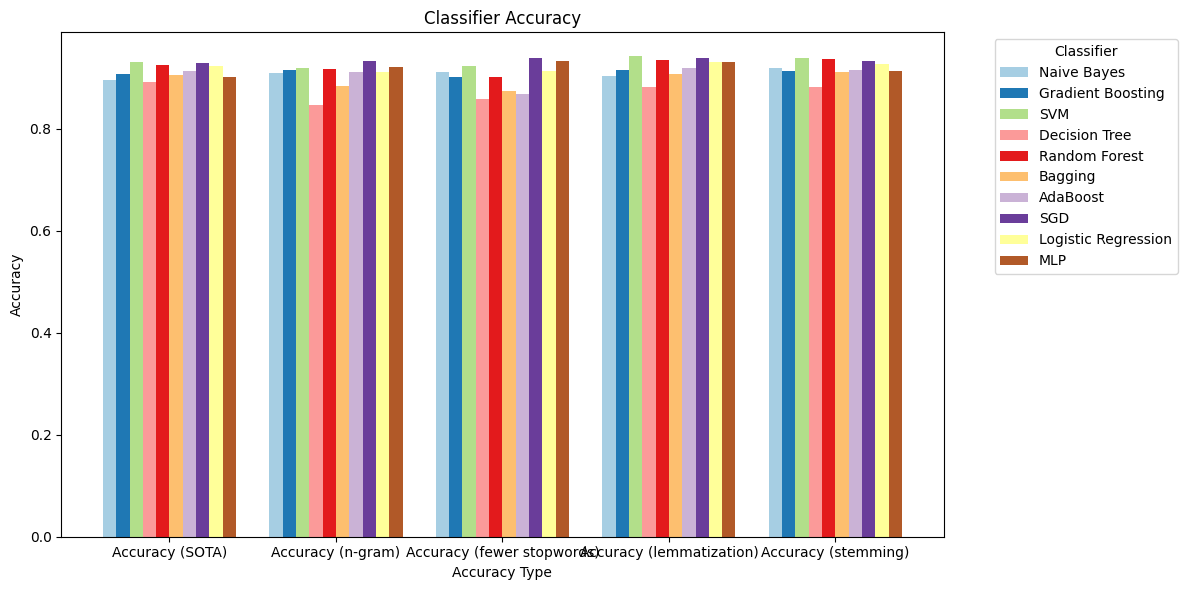

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the data for accuracy only
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'Accuracy (SOTA)': [0.8945, 0.9064, 0.9308, 0.891, 0.9238, 0.9043, 0.9133, 0.928, 0.9224, 0.9015],
    'Accuracy (n-gram)': [0.9085, 0.914, 0.9182, 0.847, 0.9175, 0.8833, 0.9099, 0.9315, 0.9105, 0.9196],
    'Accuracy (fewer stopwords)': [0.9107, 0.9002, 0.9218, 0.8583, 0.9009, 0.873, 0.8667, 0.9386, 0.9121, 0.9316],
    'Accuracy (lemmatization)': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Accuracy (stemming)': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Classifier column as the index (optional)
df.set_index('Classifier', inplace=True)

# Transpose the DataFrame for a cleaner bar chart
df = df.T

# Plot the data as a bar chart
ax = df.plot(kind='bar', figsize=(12, 6), width=0.8, colormap='Paired')
plt.title('Classifier Accuracy')
plt.xlabel('Accuracy Type')
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


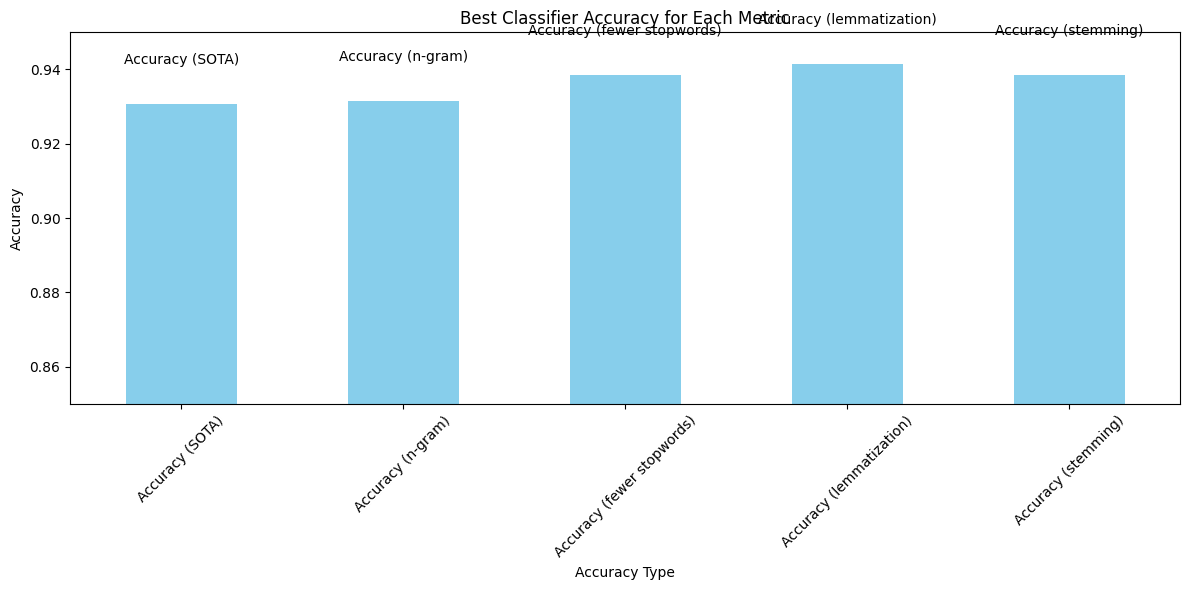

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the data for accuracy only
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'Accuracy (SOTA)': [0.8945, 0.9064, 0.9308, 0.891, 0.9238, 0.9043, 0.9133, 0.928, 0.9224, 0.9015],
    'Accuracy (n-gram)': [0.9085, 0.914, 0.9182, 0.847, 0.9175, 0.8833, 0.9099, 0.9315, 0.9105, 0.9196],
    'Accuracy (fewer stopwords)': [0.9107, 0.9002, 0.9218, 0.8583, 0.9009, 0.873, 0.8667, 0.9386, 0.9121, 0.9316],
    'Accuracy (lemmatization)': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Accuracy (stemming)': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Classifier column as the index (optional)
df.set_index('Classifier', inplace=True)

# Calculate the best accuracy for each metric
best_accuracy = df.max(axis=0)

# Plot the data as a bar chart
plt.figure(figsize=(12, 6))
ax = best_accuracy.plot(kind='bar', rot=45, color='skyblue')
plt.title('Best Classifier Accuracy for Each Metric')
plt.xlabel('Accuracy Type')
plt.ylabel('Accuracy')
plt.ylim(0.85, 0.95)  # Set the y-axis limits for better visualization
plt.tight_layout()

# Annotate the bars with the classifier names
for i, v in enumerate(best_accuracy):
    ax.text(i, v + 0.01, df.columns[i], ha='center', va='bottom', fontsize=10)

plt.show()


In [ ]:
import pandas as pd

# Create a dictionary with the data for accuracy only
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'Accuracy (SOTA)': [0.8945, 0.9064, 0.9308, 0.891, 0.9238, 0.9043, 0.9133, 0.928, 0.9224, 0.9015],
    'Accuracy (n-gram)': [0.9085, 0.914, 0.9182, 0.847, 0.9175, 0.8833, 0.9099, 0.9315, 0.9105, 0.9196],
    'Accuracy (fewer stopwords)': [0.9107, 0.9002, 0.9218, 0.8583, 0.9009, 0.873, 0.8667, 0.9386, 0.9121, 0.9316],
    'Accuracy (lemmatization)': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Accuracy (stemming)': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Classifier column as the index (optional)
df.set_index('Classifier', inplace=True)

# Specify the two columns you want to compare (e.g., 'SVM' and 'Naive Bayes')
classifier1 = 'SVM'
classifier2 = 'Naive Bayes'

# Calculate the differences in accuracy between the two specified classifiers for each metric
df_diff = df.loc[[classifier1, classifier2]].T
df_diff['Difference'] = df_diff[classifier1] - df_diff[classifier2]

# Display the table of differences
print(f"Differences in Accuracy Between {classifier1} and {classifier2} Classifiers:")
print(df_diff[['Difference']])



Differences in Accuracy Between SVM and Naive Bayes Classifiers:
Classifier                  Difference
Accuracy (SOTA)                 0.0363
Accuracy (n-gram)               0.0097
Accuracy (fewer stopwords)      0.0111
Accuracy (lemmatization)        0.0390
Accuracy (stemming)             0.0209


In [ ]:
import pandas as pd
from tabulate import tabulate

# Create a dictionary with the data for accuracy only
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'Accuracy (SOTA)': [0.8945, 0.9064, 0.9308, 0.891, 0.9238, 0.9043, 0.9133, 0.928, 0.9224, 0.9015],
    'Accuracy (n-gram)': [0.9085, 0.914, 0.9182, 0.847, 0.9175, 0.8833, 0.9099, 0.9315, 0.9105, 0.9196],
    'Accuracy (fewer stopwords)': [0.9107, 0.9002, 0.9218, 0.8583, 0.9009, 0.873, 0.8667, 0.9386, 0.9121, 0.9316],
    'Accuracy (lemmatization)': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Accuracy (stemming)': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Classifier column as the index (optional)
df.set_index('Classifier', inplace=True)

# Specify the two columns you want to compare (e.g., 'SVM' and 'Naive Bayes')
classifier1 = 'SVM'
classifier2 = 'Naive Bayes'

# Calculate the differences in accuracy between the two specified classifiers for each metric
df_diff = df.loc[[classifier1, classifier2]].T
df_diff['Difference'] = df_diff[classifier1] - df_diff[classifier2]

# Display the table of differences using tabulate
table = tabulate(df_diff[['Difference']], headers='keys', tablefmt='grid')

print(f"Differences in Accuracy Between {classifier1} and {classifier2} Classifiers:")
print(table)


Differences in Accuracy Between SVM and Naive Bayes Classifiers:
+----------------------------+--------------+
|                            |   Difference |
+============================+==============+
| Accuracy (SOTA)            |       0.0363 |
+----------------------------+--------------+
| Accuracy (n-gram)          |       0.0097 |
+----------------------------+--------------+
| Accuracy (fewer stopwords) |       0.0111 |
+----------------------------+--------------+
| Accuracy (lemmatization)   |       0.039  |
+----------------------------+--------------+
| Accuracy (stemming)        |       0.0209 |
+----------------------------+--------------+


In [ ]:
import pandas as pd

# Create a dictionary with the data for accuracy only
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'Accuracy (SOTA)': [0.8945, 0.9064, 0.9308, 0.891, 0.9238, 0.9043, 0.9133, 0.928, 0.9224, 0.9015],
    'Accuracy (n-gram)': [0.9085, 0.914, 0.9182, 0.847, 0.9175, 0.8833, 0.9099, 0.9315, 0.9105, 0.9196],
    'Accuracy (fewer stopwords)': [0.9107, 0.9002, 0.9218, 0.8583, 0.9009, 0.873, 0.8667, 0.9386, 0.9121, 0.9316],
    'Accuracy (lemmatization)': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Accuracy (stemming)': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the Classifier column as the index (optional)
df.set_index('Classifier', inplace=True)

# Specify the two columns you want to compare (e.g., 'SVM' and 'Naive Bayes')
classifier1 = 'SVM'
classifier2 = 'Naive Bayes'

# Calculate the differences in accuracy between the two specified classifiers for each metric
df_diff = df.loc[[classifier1, classifier2]].T
df_diff['Difference'] = df_diff[classifier1] - df_diff[classifier2]

# Define a function for conditional formatting
def highlight_negative(val):
    if val < 0:
        return 'background-color: red'
    elif val > 0:
        return 'background-color: green'
    else:
        return ''

# Apply conditional formatting to the 'Difference' column
styled_df = df_diff.style.applymap(highlight_negative, subset=['Difference'])

# Display the styled DataFrame
styled_df


Classifier,SVM,Naive Bayes,Difference
Accuracy (SOTA),0.930800,0.894500,0.036300
Accuracy (n-gram),0.918200,0.908500,0.009700
Accuracy (fewer stopwords),0.921800,0.910700,0.011100
Accuracy (lemmatization),0.941400,0.902400,0.039000
Accuracy (stemming),0.938600,0.917700,0.020900


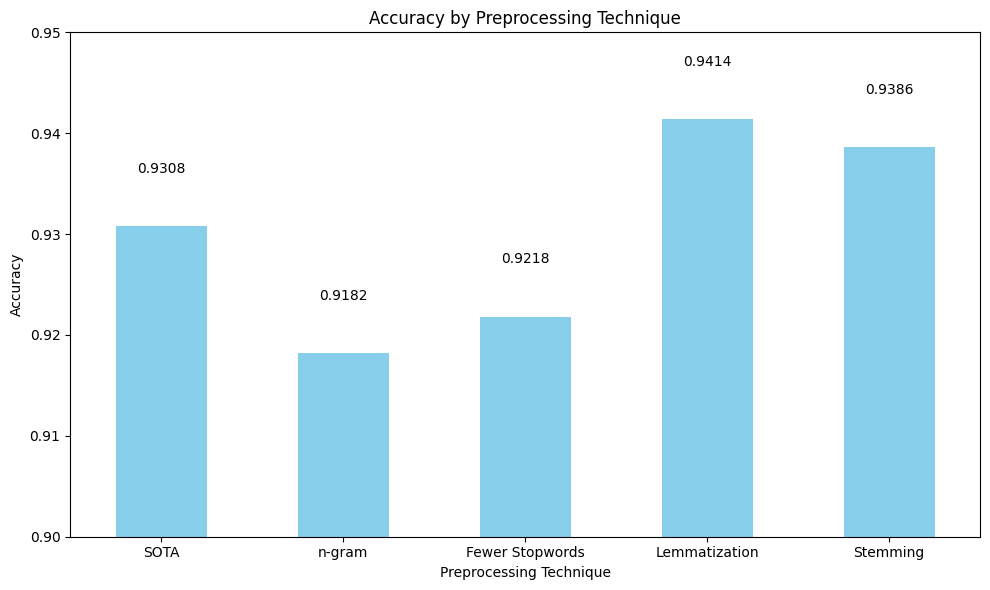

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the data for accuracy for different preprocessing techniques
data = {
    'Preprocessing Technique': ['SOTA', 'n-gram', 'Fewer Stopwords', 'Lemmatization', 'Stemming'],
    'Accuracy': [0.9308, 0.9182, 0.9218, 0.9414, 0.9386],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the 'Preprocessing Technique' column as the index (optional)
df.set_index('Preprocessing Technique', inplace=True)

# Plot the data as a bar chart
ax = df.plot(kind='bar', figsize=(10, 6), legend=False, color='skyblue')
plt.title('Accuracy by Preprocessing Technique')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Accuracy')
plt.ylim(0.9, 0.95)  # Set the y-axis limits for better visualization
plt.xticks(rotation=0)

# Annotate the bars with the accuracy values
for i, v in enumerate(df['Accuracy']):
    ax.text(i, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


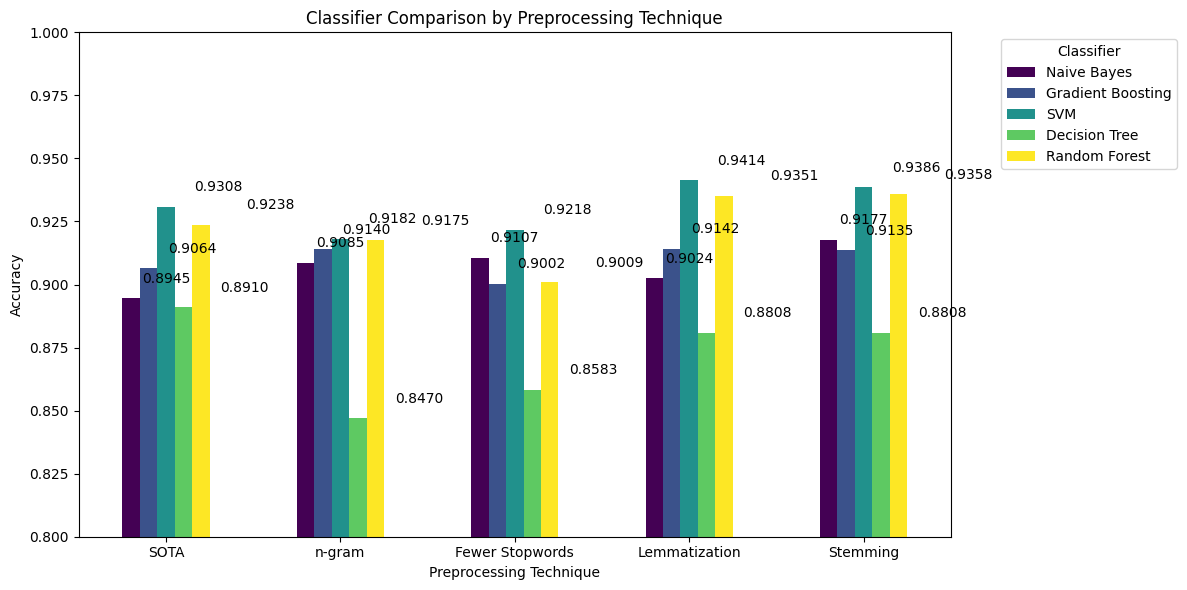

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the data for accuracy for different classifiers and preprocessing techniques
data = {
    'Preprocessing Technique': ['SOTA', 'n-gram', 'Fewer Stopwords', 'Lemmatization', 'Stemming'],
    'Naive Bayes': [0.8945, 0.9085, 0.9107, 0.9024, 0.9177],
    'Gradient Boosting': [0.9064, 0.914, 0.9002, 0.9142, 0.9135],
    'SVM': [0.9308, 0.9182, 0.9218, 0.9414, 0.9386],
    'Decision Tree': [0.891, 0.847, 0.8583, 0.8808, 0.8808],
    'Random Forest': [0.9238, 0.9175, 0.9009, 0.9351, 0.9358],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the 'Preprocessing Technique' column as the index (optional)
df.set_index('Preprocessing Technique', inplace=True)

# Plot the data as a bar chart
ax = df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0)
plt.title('Classifier Comparison by Preprocessing Technique')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Set the y-axis limits for better visualization

# Annotate the bars with the classifier names
for i, col in enumerate(df.columns):
    for j, v in enumerate(df[col]):
        ax.text(j + i * 0.15, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.legend(title='Classifier', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


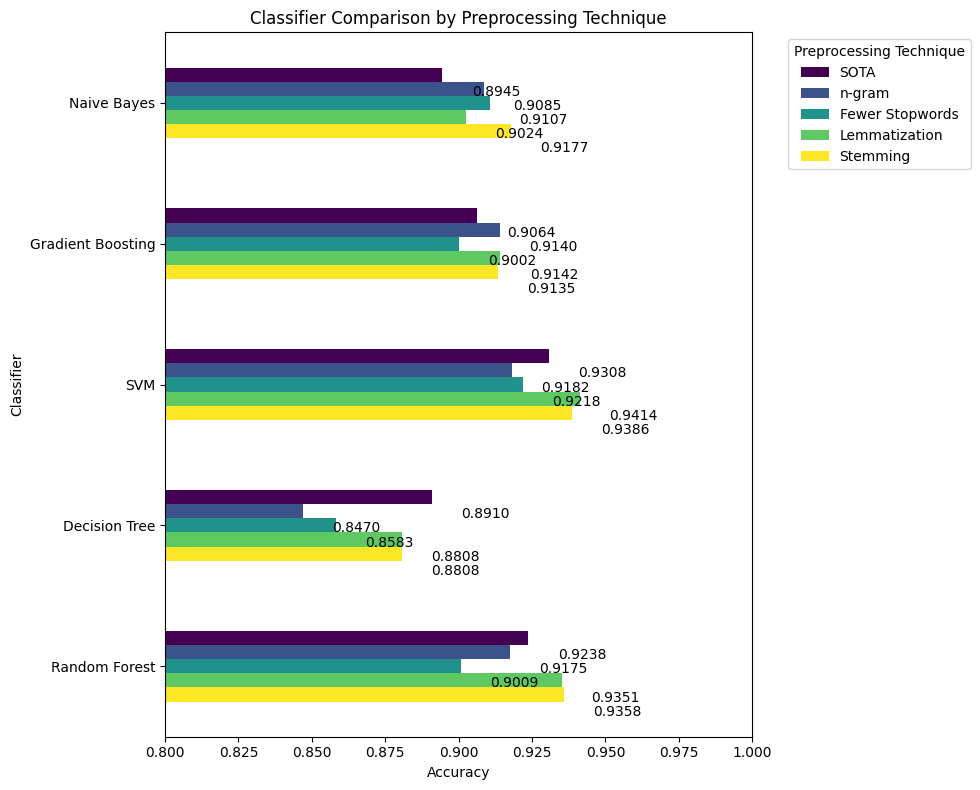

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create a dictionary with the data for accuracy for different classifiers and preprocessing techniques
data = {
    'Preprocessing Technique': ['SOTA', 'n-gram', 'Fewer Stopwords', 'Lemmatization', 'Stemming'],
    'Naive Bayes': [0.8945, 0.9085, 0.9107, 0.9024, 0.9177],
    'Gradient Boosting': [0.9064, 0.914, 0.9002, 0.9142, 0.9135],
    'SVM': [0.9308, 0.9182, 0.9218, 0.9414, 0.9386],
    'Decision Tree': [0.891, 0.847, 0.8583, 0.8808, 0.8808],
    'Random Forest': [0.9238, 0.9175, 0.9009, 0.9351, 0.9358],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the 'Preprocessing Technique' column as the index (optional)
df.set_index('Preprocessing Technique', inplace=True)

# Transpose the DataFrame for better visualization
df = df.T

# Plot the data as a horizontal bar chart
ax = df.plot(kind='barh', figsize=(10, 8), colormap='viridis')

# Customize the plot
plt.title('Classifier Comparison by Preprocessing Technique')
plt.xlabel('Accuracy')
plt.ylabel('Classifier')
plt.xlim(0.8, 1.0)  # Set the x-axis limits for better visualization

# Annotate the bars with the accuracy values
for i in ax.patches:
    ax.text(i.get_width() + 0.01, i.get_y() + 0.2, f'{i.get_width():.4f}', fontsize=10)

plt.legend(title='Preprocessing Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # Invert the y-axis to show the best at the top
plt.tight_layout()
plt.show()


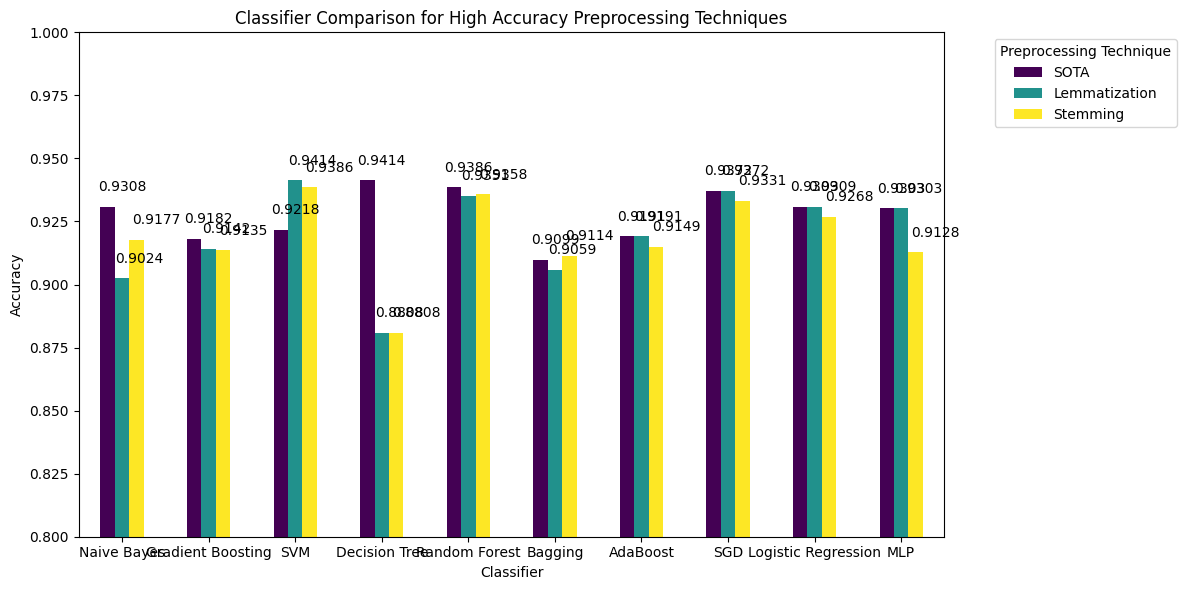

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a dictionary with the data for accuracy for different classifiers and preprocessing techniques
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'SOTA': [0.9308, 0.9182, 0.9218, 0.9414, 0.9386, 0.9099, 0.9191, 0.9372, 0.9309, 0.9303],
    'Lemmatization': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Stemming': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the dictionary
df = pd.DataFrame(data)

# Set the 'Classifier' column as the index (optional)
df.set_index('Classifier', inplace=True)

# Select only the columns for SOTA, Lemmatization, and Stemming
selected_df = df[['SOTA', 'Lemmatization', 'Stemming']]

# Plot the data as a bar chart
ax = selected_df.plot(kind='bar', figsize=(12, 6), colormap='viridis', rot=0)
plt.title('Classifier Comparison for High Accuracy Preprocessing Techniques')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0.8, 1.0)  # Set the y-axis limits for better visualization

# Annotate the bars with the accuracy values
for i, col in enumerate(selected_df.columns):
    for j, v in enumerate(selected_df[col]):
        ax.text(j + i * 0.2, v + 0.005, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.legend(title='Preprocessing Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


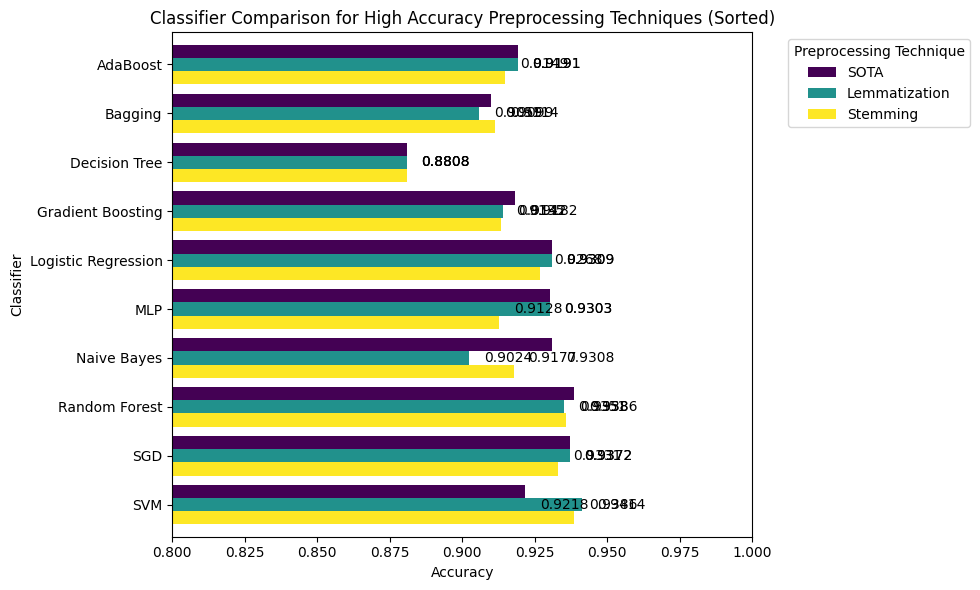

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Corrected data for accuracy for different classifiers and preprocessing techniques
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'SOTA': [0.9308, 0.9182, 0.9218, 0.8808, 0.9386, 0.9099, 0.9191, 0.9372, 0.9309, 0.9303],
    'Lemmatization': [0.9024, 0.9142, 0.9414, 0.8808, 0.9351, 0.9059, 0.9191, 0.9372, 0.9309, 0.9303],
    'Stemming': [0.9177, 0.9135, 0.9386, 0.8808, 0.9358, 0.9114, 0.9149, 0.9331, 0.9268, 0.9128],
}

# Create a pandas DataFrame from the corrected data
df = pd.DataFrame(data)

# Set the 'Classifier' column as the index (optional)
df.set_index('Classifier', inplace=True)

# Select only the columns for SOTA, Lemmatization, and Stemming
selected_df = df[['SOTA', 'Lemmatization', 'Stemming']]

# Sort the classifiers within each preprocessing technique by accuracy (low to high)
selected_df = selected_df.apply(lambda x: x.sort_values(ascending=True))

# Create a horizontal bar chart with improved formatting
fig, ax = plt.subplots(figsize=(10, 6))
selected_df.plot(kind='barh', ax=ax, colormap='viridis', width=0.8)

# Customize the plot
plt.title('Classifier Comparison for High Accuracy Preprocessing Techniques (Sorted)')
plt.xlabel('Accuracy')
plt.ylabel('Classifier')
plt.xlim(0.8, 1.0)  # Set the x-axis limits for better visualization

# Annotate the bars with the accuracy values
for i, col in enumerate(selected_df.columns):
    for j, v in enumerate(selected_df[col]):
        ax.text(v + 0.005, j, f'{v:.4f}', va='center', fontsize=10)

plt.legend(title='Preprocessing Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # Invert the y-axis to show the best at the top
plt.tight_layout()
plt.show()


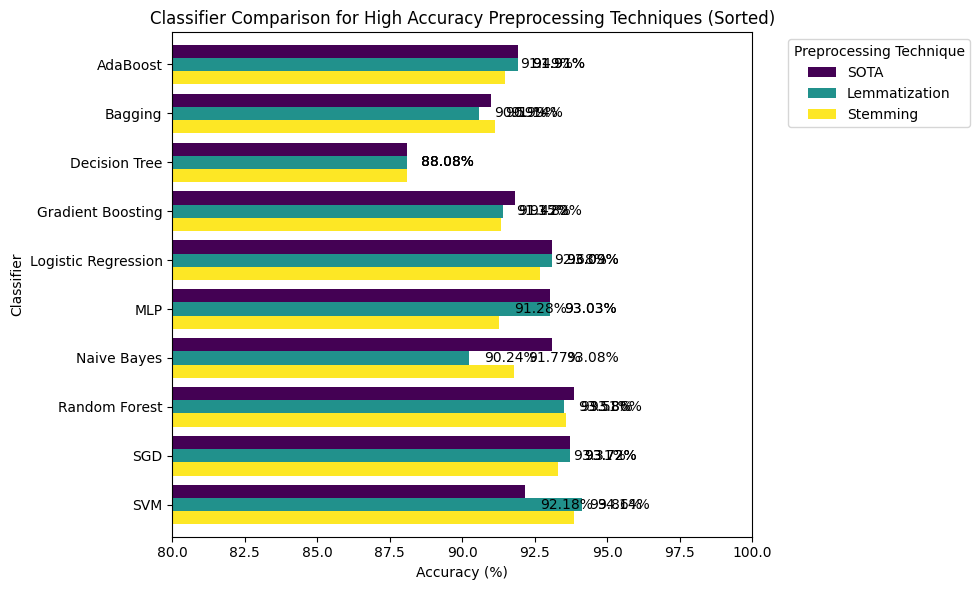

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Corrected data for accuracy for different classifiers and preprocessing techniques
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'SOTA': [93.08, 91.82, 92.18, 88.08, 93.86, 90.99, 91.91, 93.72, 93.09, 93.03],
    'Lemmatization': [90.24, 91.42, 94.14, 88.08, 93.51, 90.59, 91.91, 93.72, 93.09, 93.03],
    'Stemming': [91.77, 91.35, 93.86, 88.08, 93.58, 91.14, 91.49, 93.31, 92.68, 91.28],
}

# Create a pandas DataFrame from the corrected data
df = pd.DataFrame(data)

# Set the 'Classifier' column as the index (optional)
df.set_index('Classifier', inplace=True)

# Select only the columns for SOTA, Lemmatization, and Stemming
selected_df = df[['SOTA', 'Lemmatization', 'Stemming']]

# Sort the classifiers within each preprocessing technique by accuracy (low to high)
selected_df = selected_df.apply(lambda x: x.sort_values(ascending=True))

# Create a horizontal bar chart with improved formatting
fig, ax = plt.subplots(figsize=(10, 6))
selected_df.plot(kind='barh', ax=ax, colormap='viridis', width=0.8)

# Customize the plot
plt.title('Classifier Comparison for High Accuracy Preprocessing Techniques (Sorted)')
plt.xlabel('Accuracy (%)')
plt.ylabel('Classifier')
plt.xlim(80, 100)  # Set the x-axis limits for better visualization

# Annotate the bars with the accuracy values
for i, col in enumerate(selected_df.columns):
    for j, v in enumerate(selected_df[col]):
        ax.text(v + 0.5, j, f'{v:.2f}%', va='center', fontsize=10)

plt.legend(title='Preprocessing Technique', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.gca().invert_yaxis()  # Invert the y-axis to show the best at the top
plt.tight_layout()
plt.show()


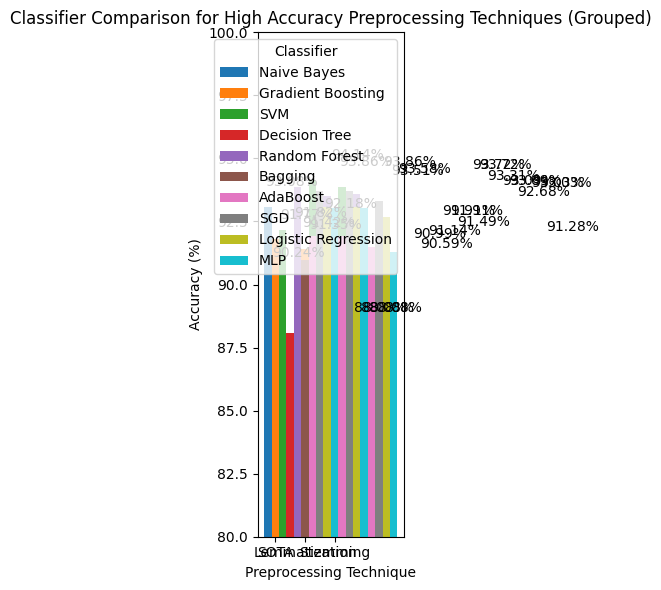

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Corrected data for accuracy for different classifiers and preprocessing techniques
data = {
    'Classifier': ['Naive Bayes', 'Gradient Boosting', 'SVM', 'Decision Tree', 'Random Forest', 'Bagging', 'AdaBoost', 'SGD', 'Logistic Regression', 'MLP'],
    'SOTA': [93.08, 91.82, 92.18, 88.08, 93.86, 90.99, 91.91, 93.72, 93.09, 93.03],
    'Lemmatization': [90.24, 91.42, 94.14, 88.08, 93.51, 90.59, 91.91, 93.72, 93.09, 93.03],
    'Stemming': [91.77, 91.35, 93.86, 88.08, 93.58, 91.14, 91.49, 93.31, 92.68, 91.28],
}

# Create a pandas DataFrame from the corrected data
df = pd.DataFrame(data)

# Set the 'Classifier' column as the index (optional)
df.set_index('Classifier', inplace=True)

# Filter the DataFrame for only the selected preprocessing techniques
selected_df = df[['SOTA', 'Lemmatization', 'Stemming']]

# Transpose the DataFrame for better formatting
selected_df = selected_df.T

# Create a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))
width = 0.25  # Width of each bar
x = np.arange(len(selected_df.index))

for i, col in enumerate(selected_df.columns):
    ax.bar(x + i * width, selected_df[col], width, label=col)

# Customize the plot
plt.title('Classifier Comparison for High Accuracy Preprocessing Techniques (Grouped)')
plt.xlabel('Preprocessing Technique')
plt.ylabel('Accuracy (%)')
plt.ylim(80, 100)  # Set the y-axis limits for better visualization
plt.xticks(x + width, selected_df.index)
plt.legend(title='Classifier')

# Annotate the bars with the accuracy values
for i in range(len(selected_df.index)):
    for j, v in enumerate(selected_df.iloc[i]):
        ax.text(j + i * width - 0.1, v + 1, f'{v:.2f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving fakeNews.csv to fakeNews.csv
Saving trueNews.csv to trueNews.csv


In [ ]:
import pandas as pd

# Paths to the datasets
#fake_news_path = 'path/to/fakeNews.csv'
#true_news_path = 'path/to/trueNews.csv'

# Load the datasets
fake_news_df = pd.read_csv('fakeNews.csv')
true_news_df = pd.read_csv('trueNews.csv')


In [ ]:
# Count the number of observations in each dataset
num_observations_fake = fake_news_df.shape[0]
num_observations_true = true_news_df.shape[0]

print(f'Number of fake news observations: {num_observations_fake}')
print(f'Number of true news observations: {num_observations_true}')


Number of fake news observations: 3795
Number of true news observations: 3793


In [ ]:
# Add a label column to each dataset
fake_news_df['label'] = 'fake'
true_news_df['label'] = 'true'

# Combine the datasets
combined_df = pd.concat([fake_news_df, true_news_df], ignore_index=True)

# Count the occurrences of each class
class_balance = combined_df['label'].value_counts()

print(class_balance)


fake    3795
true    3793
Name: label, dtype: int64


In [ ]:
# Calculate the total number of observations
total_observations = combined_df.shape[0]

# Calculate the count of each class
class_counts = combined_df['label'].value_counts()

# Calculate the proportion of each class
class_proportions = class_counts / total_observations

print(f'Total number of observations: {total_observations}')
print(f'Class proportions:\n{class_proportions}')


Total number of observations: 7588
Class proportions:
fake    0.500132
true    0.499868
Name: label, dtype: float64


In [ ]:
# Assuming fake_news_df is DataFrame for the fake news dataset
num_columns_fake = fake_news_df.shape[1]
print(f'Number of columns in the fake news dataset: {num_columns_fake}')


Number of columns in the fake news dataset: 12


In [ ]:
# Assuming true_news_df is DataFrame for the true news dataset
num_columns_true = true_news_df.shape[1]
print(f'Number of columns in the true news dataset: {num_columns_true}')


Number of columns in the true news dataset: 8
